In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext

from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
#!pip install spacy --upgrade

Since in this assignment, we are only working on English, spacy for english only is needed.

In [4]:
%%bash
python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [6]:
spacy_en = spacy.load('en_core_web_sm')

In [7]:
def tokenize_n(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)] #[::-1]

In [8]:
QUE1 = Field(tokenize = tokenize_n,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

QUE2 = Field(tokenize = tokenize_n, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [9]:
fields = [('que1', QUE1),('que2',QUE2)]

In [10]:
from  torchtext.legacy import data
import pandas as pd

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Only those question pairs have to be selected for which duplicate is true. 

In [12]:
df=(pd.read_csv('/content/drive/MyDrive/quora_duplicate_questions.tsv',sep='\t',
               header=0,lineterminator='\n',dtype=pd.StringDtype(),encoding = "ISO-8859-1",
               names= ['id','qid1','qid2','question1','question2','is_duplicate'],
               usecols = ['question1','question2','is_duplicate']))[lambda x: x['is_duplicate'] =='1']

## Overview of the Question Pair Dataset from Quora

The file "quora_duplicate_questions.tsv" contains the questions-question pairs. The first line of the file contains 
column names for the tab-separated data fields in the file, which are:

id qid1 qid2 question1 question2 is_duplicate

Since we are only focussing on the text part of the dataset, which is question1 and question2, I am only picking up these two columns along with is_duplicate to select only those rows for which is_duplicate is true.

So here is number of samples which get selected.

In [ ]:
df.shape

(149263, 3)

Some idea of what the data looks like

In [ ]:
df.head()

,question1,question2,is_duplicate
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,How can I be a good geologist?,What should I do to be a great geologist?,1
11,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,What was your first sexual experience like?,What was your first sexual experience?,1


The first column values which are treated as index now do not have a running number. So needed to reset the index values.

In [13]:
df=df.reset_index(drop=True)

Another glimpse of the final data with correct indexing

In [14]:
df.head()

,question1,question2,is_duplicate
0,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
1,How can I be a good geologist?,What should I do to be a great geologist?,1
2,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
3,What can make Physics easy to learn?,How can you make physics easy to learn?,1
4,What was your first sexual experience like?,What was your first sexual experience?,1


Lets first create the DataFrame

In [15]:
example = [torchtext.legacy.data.Example.fromlist([str(df.question1[i]),str(df.question2[i])], fields) for i in range(df.shape[0])]

Now create the dataset


In [16]:
from torchtext.legacy import data
QQDataset=data.Dataset(example,fields)

Finally, we can split into training  and test sets by using the split() method:

In [17]:
(train_set, test_set) = QQDataset.split(split_ratio=[0.70, 0.30], random_state=random.seed(SEED))

In [18]:
print(f"Number of training examples: {len(train_set.examples)}")
print(f"Number of testing examples: {len(test_set.examples)}")

Number of training examples: 104484
Number of testing examples: 44779


In [19]:
QUE1.build_vocab(train_set, min_freq = 2)
QUE2.build_vocab(train_set, min_freq = 2)

In [ ]:
print(f"Unique tokens in source  vocabulary: {len(QUE1.vocab)}")
print(f"Unique tokens in target vocabulary: {len(QUE2.vocab)}")

Unique tokens in source  vocabulary: 14579
Unique tokens in target vocabulary: 14533


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
BATCH_SIZE = 128

train_iterator,  test_iterator = BucketIterator.splits(
    (train_set, test_set), sort_key = lambda x: len(x.que1),
    sort_within_batch=True,
    batch_size = BATCH_SIZE, 
    device = device)

#Perplexity
In the context of Natural Language Processing, perplexity is one way to evaluate language models.  is not just enough to produce text; we also need a way to measure the quality of the produced text. One such way is to measure how surprised or **perplexed** the RNN was to see the output given the input. That is, if the cross-entropy loss for an input $x_i$ and its corresponding output $y_i$ is $loss(x_i,y_i)$ , then the perplexity would be as follows:

$P(x_i,y_i)=e^{loss(x_i,y_i)}$ </br>
Using this, we can compute the average perplexity for a training dataset of size M as:
$PPL(Dataset_{train})=\frac{1}{M}\sum_{i}^{M} P(x_i,y_i)$

Question now is what is cross entropy? </br>
Lets first understand the definition of entropy given by Shannon. </br>
Shannon's Entropy is defined as $E(p)=-\sum_{i=1}^np(x_i)log_bp(x_i)$ </br>
  where $b$ is the base of logarithm used, $n$ is the number of states, and $p(x_i)$ is the probability of system being in state $i$, and $\sum_{i=1}^n p(x_i)=1.

So,  Shannon entropy tells us that the  if a system can be in four possible states,and we know the probability of the system being in any one of the states, then for an infintely long sequence of states, how much minimum memory do we need to store the state of the system.

Now Lets look at cross entropy.</br>
As the word 'cross' implies, we have two different distributions, say $p$ and $q$, then cross entropy $CE(p,q) = -\sum_{i=1}^np(x_i)log_bq(x_i)$.</br>
So, lets say we have two different systems say $S1$ and $S2$, with two different probability distributions $p$ and $q$. Then cross entropy tells us, for an infinitely large sequence of states, drawn from system $S1$ with probability distribution $p$ and from system $S2$, with probability distribution $q$, how much minimum memory do we need on average to store the states. </br>
$E(p)$ will always be less than cross entropy. If $p=q$, CE(p,q)$ will be equal to $E(p)$, and will be at its minimum value.</br>

Now lets look at Perplexity.</br>
Preplexity is defined with cross entropy as :</br>
$PPL(p)=b^{E(p)}$ </br>
But what is the pupose of Perplexity in language modeling?</br>
If we take M different sentences in the dataset, then these M different sequences represent $m$ different possible states (Some of them same). Now we are building the language model, the original system has states distributed with probability $p$, which have no way to know. We can only estimate that probability distribution by, say, $q$. Then the cross_entropy is CE(p,q), which we also call as cross entropy loss. So for each sequence of states (i.e. sentences), we can write that as $loss(x_i,y_i)=CE(p(x_i),q(y_i))$, where $x_i$ comes from the original system $S1$ and $y_i$ comes from the system $S2$ we are trying to model.</br>

If the language model (the one we are bulding) is of extremely low quality, and the words in the sentence are guessed randomly, with each word chosen in equally likely manner, then $q(w_i|w_1,w_2...w_{i-1})=\frac{1}{m}$, log of this number will be very high ($m$ being very large, making $\frac{1}{m}$ very small), and hence CE will be very high, leading to high perplexity.

But if a model is better, and has actually learned something, then the probability $q$ of a valid sentence like "I like apples" is very high (hence log of that very small, hence small preplexity), as compared to an invalid sentence like " apple fly state".

So as the model learns with each epoch, loss reduces and so is the preplexity. So lower the perplxity better is the model.

In [22]:
import math

In [39]:
#Code for perplexity
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
def prplxity(l):
  #loss=criterion(pred, y) #criterion uses the loss function as cross entropy loss.
  #l=loss.item()
  ppl=math.exp(l)
  return ppl


In [23]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.lstm(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [24]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [25]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [26]:
INPUT_DIM = len(QUE1.vocab)
OUTPUT_DIM = len(QUE2.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [27]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14579, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(14533, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=14533, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,264,517 trainable parameters


In [29]:
optimizer = optim.Adam(model.parameters())

In [30]:
TRG_PAD_IDX = QUE2.vocab.stoi[QUE2.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

My Trials to understand the shape of ouputs etc.Pls Ignore next two cells

In [ ]:
b=next(iter(train_iterator))
src,trg=b.que1,b.que2

In [ ]:
o=model(src,trg)
ou_dim = o.shape[-1]
output = o[1:].view(-1, ou_dim)
tr = trg[1:].view(-1)
optimizer.zero_grad()
loss = criterion(output, tr)
loss.backward()
clip=1      
torch.nn.utils.clip_grad_norm_(model.parameters(), clip)      
optimizer.step()

In [41]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.que1
        trg = batch.que2
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
    avloss=epoch_loss / len(iterator)
    ppl=prplxity(avloss)      
    return avloss,ppl

In [42]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.que1
            trg = batch.que2

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
    avloss=epoch_loss / len(iterator)
    ppl=prplxity(avloss)      
    return avloss,ppl

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
import torch
torch.cuda.empty_cache()

In [35]:
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
import numpy as np

In [44]:
 
N_EPOCHS = 10
CLIP = 1
global plot_iter, plot_loss_train, plot_loss_val,plot_ppl_train,plot_ppl_test
plot_iter = np.zeros((0))
plot_loss_train = np.zeros((0))
plot_loss_val = np.zeros((0))
plot_ppl_train = np.zeros((0))
plot_ppl_test = np.zeros((0))
best_test_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss,train_ppl = train(model, train_iterator, optimizer, criterion, CLIP)
    test_loss, test_ppl = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. PPL: {test_ppl:7.3f}')
    plot_iter = np.append(plot_iter, [epoch])
    plot_loss_train = np.append(plot_loss_train, [train_loss])
    plot_loss_ = np.append(plot_loss_val, [test_loss])
    plot_ppl_train = np.append(plot_ppl_train, [train_ppl])
    plot_ppl_test = np.append(plot_ppl_test, [test_ppl])

Epoch: 01 | Time: 4m 22s
	 Train Loss: 2.990 | Train PPL:  19.893
	 Val. Loss: 3.761 |  Val. PPL:  42.991
Epoch: 02 | Time: 4m 22s
	 Train Loss: 2.753 | Train PPL:  15.688
	 Val. Loss: 3.672 |  Val. PPL:  39.312
Epoch: 03 | Time: 4m 22s
	 Train Loss: 2.576 | Train PPL:  13.147
	 Val. Loss: 3.580 |  Val. PPL:  35.856
Epoch: 04 | Time: 4m 21s
	 Train Loss: 2.433 | Train PPL:  11.396
	 Val. Loss: 3.599 |  Val. PPL:  36.571
Epoch: 05 | Time: 4m 20s
	 Train Loss: 2.303 | Train PPL:  10.003
	 Val. Loss: 3.581 |  Val. PPL:  35.924
Epoch: 06 | Time: 4m 21s
	 Train Loss: 2.201 | Train PPL:   9.035
	 Val. Loss: 3.574 |  Val. PPL:  35.660
Epoch: 07 | Time: 4m 20s
	 Train Loss: 2.130 | Train PPL:   8.416
	 Val. Loss: 3.571 |  Val. PPL:  35.562
Epoch: 08 | Time: 4m 20s
	 Train Loss: 2.071 | Train PPL:   7.934
	 Val. Loss: 3.569 |  Val. PPL:  35.486
Epoch: 09 | Time: 4m 20s
	 Train Loss: 2.002 | Train PPL:   7.403
	 Val. Loss: 3.600 |  Val. PPL:  36.588
Epoch: 10 | Time: 4m 20s
	 Train Loss: 1.951 |

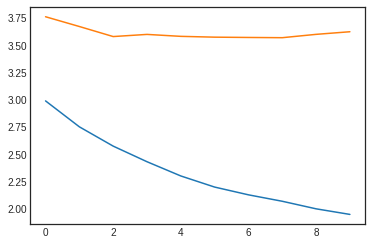

In [46]:
plt.plot(plot_iter, plot_loss_train, plot_loss_val)
display.clear_output(wait=True)
plt.show()

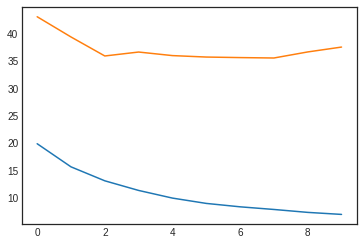

In [50]:
plt.plot(plot_iter, plot_ppl_train, plot_ppl_test)
display.clear_output(wait=True)
plt.show()

It can be seen that the train perplexity is gradully reducing with each epoch, as the model is getting better in predicting the text based on what it has seen. So it slowly aligns itself with seen examples and adjusts the probabilites better. So the cross entropy loss reducing leading to a low value for training perplexity. However, the validation perplexity is fluctuating significantly. This is expected because what we are essentially evaluating in the validation perplexity is our model's ability to predict a unseen text based on our learning on training data. Since language can be quite difficult to model, this is a very difficult task, and these fluctuations are natural.

Also it can be seen that fluctuations in perplexity are in line with fluctuations in the loss curve.

In [52]:
from google.colab import files
files.download('tut1-model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>